# Binomial Tree

In [2]:
import math

def european_option_binomial(S0, K, T, r, sigma, N, option_type="call"):

    # Step size
    dt = T / N
    # Up and down factors
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (math.exp(r * dt) - d) / (u - d)
    discount = math.exp(-r * dt)

    # Initialize asset prices at maturity
    ST = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]

    # Initialize option values at maturity
    if option_type == "call":
        option_values = [max(s - K, 0) for s in ST]
    elif option_type == "put":
        option_values = [max(K - s, 0) for s in ST]
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Step back through the tree
    for i in range(N - 1, -1, -1):
        option_values = [
            discount * (p * option_values[j + 1] + (1 - p) * option_values[j])
            for j in range(i + 1)
        ]

    return option_values[0]




In [3]:
S0 = 606.78      
K = 610
Days_till_expiration = 5
T = Days_till_expiration / 252       
r = 0.055
sigma = 0.20581   
N = 5      

call_price = european_option_binomial(S0, K, T, r, sigma, N, option_type="call")
put_price = european_option_binomial(S0, K, T, r, sigma, N, option_type="put")

print(f"European Call Price: {call_price:.4f}")
print(f"European Put Price:  {put_price:.4f}")

European Call Price: 6.0664
European Put Price:  8.6211


# Black and scholes Model

In [4]:
import math
from scipy.stats import norm

def black_scholes_no_dividend(S, K, T, r, sigma, option_type="call"):
    
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return price


In [5]:
def black_scholes_with_dividend(S, K, T, r, sigma, q, option_type="call"):
    
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == "call":
        price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return price


In [6]:
S = 603.291
K = 602
Days_till_expiration = 7
T = Days_till_expiration / 365
r = 0.0424
sigma = 0.1281
q = 0.0117

# No dividends
call_nd = black_scholes_no_dividend(S, K, T, r, sigma, "call")
put_nd = black_scholes_no_dividend(S, K, T, r, sigma, "put")

# With dividends
call_d = black_scholes_with_dividend(S, K, T, r, sigma, q, "call")
put_d = black_scholes_with_dividend(S, K, T, r, sigma, q, "put")

print(f"Black-Scholes without dividend - Call: {call_nd:.4f}, Put: {put_nd:.4f}")
print(f"Black-Scholes with dividend    - Call: {call_d:.4f}, Put: {put_d:.4f}")


Black-Scholes without dividend - Call: 5.2124, Put: 3.4321
Black-Scholes with dividend    - Call: 5.1357, Put: 3.4907


# Monte Carlo Simulation Method

## European Option pricing

In [18]:
# Simulate Geometric Brownian Motion
import numpy as np
import matplotlib.pyplot as plt
# number of paths
n = 100000
#number of steps
m = 252
# Interest rate (We set the drift equal to the interest rate for the risk-neutral probability)
r = 0.1
# Volatility
sig = 0.2
# Initial Stock Price
S0 = 42
# Maturity
T = 1
#Strike Price
K=40
# Dividend Yield
q=0.0
# Delta t
dt = T/m
# Drift (nu)
drift = (r-q-0.5*sig**2)
# Volatility
vol = sig * np.sqrt(dt)

t = np.array(range(0,m + 1,1)) * dt

# seed for random generator
seed= 42
# define a random generator
np.random.seed(seed)
inc = np.zeros(shape = (m + 1, n))
inc[1:] = np.transpose(np.random.normal(loc = 0, scale = vol,size = (n,m)))
St = np.zeros(shape = (m + 1, n))
St = S0 * np.exp(np.cumsum(inc,axis=0) + (drift * t[0:m + 1])[:,None])
St_antithetic = S0 * np.exp(-np.cumsum(inc,axis=0) + (drift * t[0:m + 1])[:,None])
cc=np.maximum(St[m,:]-K,0)
cp = np.mean(cc) * np.exp(-r * T)
cc1=np.maximum(St_antithetic[m,:]-K,0)*np.exp(-r * T)
cp1= np.mean(np.maximum(St_antithetic[m,:]-K,0)) * np.exp(-r * T)

print('The first sample gives an estimated call price=',cp)
print('The second sample gives an estimated call price=',cp1)
bsc = (cp+cp1)/2
print('The average of the two estimates=',bsc)

The first sample gives an estimated call price= 6.8218549297986995
The second sample gives an estimated call price= 6.8295449565530895
The average of the two estimates= 6.825699943175895


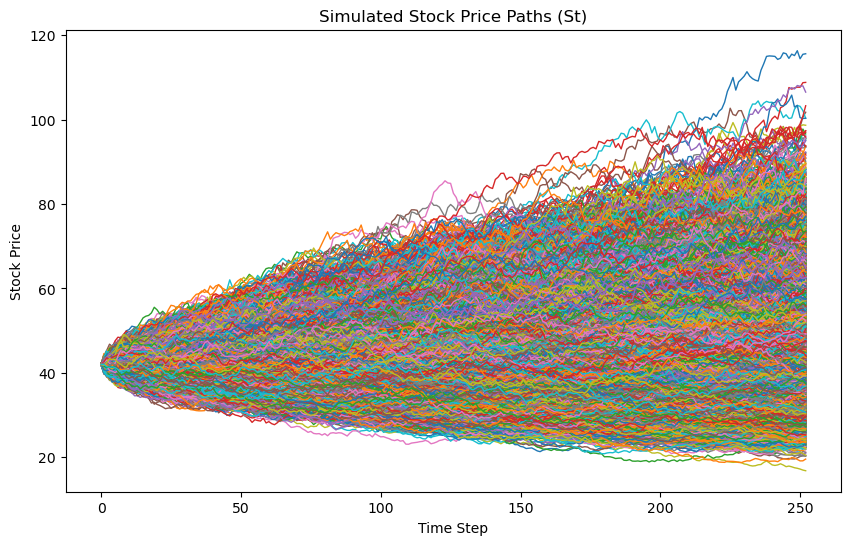

In [19]:
#plot St
plt.figure(figsize=(10,6))
for i in range(n):  # Plot 10 sample paths for clarity
    plt.plot(St[:, i], lw=1)
plt.title("Simulated Stock Price Paths (St)")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.show()

In [20]:
import numpy as np
from scipy.stats import norm

# === PARAMETERS ===
S0 = 42             # Initial stock price
K = 40              # Strike price
r = 0.1             # Risk-free rate
sigma = 0.2         # Volatility
T = 1               # Time to maturity (in years)

# === BLACK-SCHOLES FORMULA ===
def black_scholes_price(S, K, r, sigma, T, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

# === COMPUTE PRICES ===
call_price = black_scholes_price(S0, K, r, sigma, T, option_type='call')
put_price = black_scholes_price(S0, K, r, sigma, T, option_type='put')

# === DISPLAY ===
print(f"Black-Scholes European Call Price: {call_price:.4f}")



Black-Scholes European Call Price: 6.8371


### Control Variates

In [21]:
SS=np.mean(St[m,:])*np.exp(-r*T)
print('The Estimated Stock Price for the first sample is =', SS)
print('The actual stock price should be=', S0)
print('The error is =', S0-SS)

The Estimated Stock Price for the first sample is = 41.98759822845876
The actual stock price should be= 42
The error is = 0.012401771541242113


In [22]:
hatbeta= np.cov(St[m,:],cc)[0,1]/np.cov(St[m,],cc)[1,1]
hatbeta1=np.cov(St_antithetic[m,:],cc1)[0,1]/np.cov(St_antithetic[m,],cc1)[1,1]
correction =hatbeta*(S0-SS)
update=cp + correction
print('hatbeta=',hatbeta)
print('The original estimate for the call price from the first sample=',cp)
print('The original estimate for the call price from the second sample=',cp1)
print('The updated estimate from the first sample is=',update)
SS1=np.mean(St_antithetic[m,:])*np.exp(-r*T)
update1=cp1+hatbeta1*(S0-SS1)
print('The updated estimate from the second sample is=',update1)
print('The average of the updated estimates =',(update+update1)/2)

hatbeta= 1.1347667125667071
The original estimate for the call price from the first sample= 6.8218549297986995
The original estimate for the call price from the second sample= 6.8295449565530895
The updated estimate from the first sample is= 6.835928047320558
The updated estimate from the second sample is= 6.824962723206131
The average of the updated estimates = 6.830445385263344


## Asian Option Pricing (MC)

In [2]:
# Simulate Geometric Brownian Motion
import numpy as np
import matplotlib.pyplot as plt
# number of paths
n = 100000
#number of steps
m = 252
# Interest rate (We set the drift equal to the interest rate for the risk-neutral probability)
r = 0.1
# Volatility
sig = 0.2
# Initial Stock Price
S0 = 42
# Maturity
T = 1
#Strike Price
K=40
# Dividend Yield
q=0.0
# Delta t
dt = T/m
# Drift (nu)
drift = (r-q-0.5*sig**2)
# Volatility
vol = sig * np.sqrt(dt)

t = np.array(range(0,m + 1,1)) * dt

# seed for random generator
seed= 42
# define a random generator
np.random.seed(seed)
inc = np.zeros(shape = (m + 1, n))
inc[1:] = np.transpose(np.random.normal(loc = 0, scale = vol,size = (n,m)))
St = np.zeros(shape = (m + 1, n))
St = S0 * np.exp(np.cumsum(inc,axis=0) + (drift * t[0:m + 1])[:,None])

s_avg = np.mean(St[1:],axis=0)
call_payoff=np.maximum(s_avg-K,0)
call_price = np.mean(call_payoff) * np.exp(-r * T)

put_price = np.maximum(K-St[m,:],0)
put_payoff = np.mean(put_price) * np.exp(-r * T)


print('The Asian option call price:{}'.format(call_price))
print('The Asian option call price:{}'.format(call_price))


The Asian option call price:4.2521979881908365
The Asian option call price:4.2521979881908365
